In [1]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

import torch
import torch.nn as nn

from sklearn.metrics import RocCurveDisplay

from Data.Station_data import StationDataloader
from Models.GANomaly.GANomaly_station import GANomaly
from Utils.Visualizer import cal_best_threshold, plot_distribution, plot_image

In [2]:
args = OmegaConf.load('../Config/station_GANomaly_config.yaml')
np.random.seed(0)
torch.manual_seed(0)
args

{'experiment_name': 'GANomaly_station_final', 'dataroot': '../Datasets/station', 'experiment_path': './Experiments/GANomaly/station', 'checkpoint_save': './Experiments/GANomaly/station/checkpoint', 'checkpoint_load': '../checkpoint/GANomaly/Station/512_0.84/checkpoint_best.pt', 'log_path': './Experiments/GANomaly/station/GANomaly_station.log', 'start_epoch': 1, 'finish_epoch': 300, 'manualseed': 42, 'batchSize': 64, 'imageSize_h': 86, 'imageSize_w': 64, 'nc': 3, 'nz': 512, 'ngf': 64, 'n_extra_layers': 0, 'device': 'gpu', 'gpu_ids': 0, 'ngpu': 1, 'lr': 0.0005, 'b1': 0.5, 'b2': 0.999, 'w_adv': 1, 'w_con': 30, 'w_enc': 1, 'reset_disc_value': 1e-05, 'sample_interval': 50}

In [3]:
train_loader, val_loader = StationDataloader(args.dataroot, batchSize=args.batchSize, imageSize_h=args.imageSize_h, imageSize_w=args.imageSize_w, is_train=True)
test_neg_loader, test_pos_loader = StationDataloader(args.dataroot, batchSize=args.batchSize, imageSize_h=args.imageSize_h, imageSize_w=args.imageSize_w, is_train=False)

In [4]:
Tester = GANomaly(args)

{'gen_epoch_loss': 26.122262115478517, 'disc_epoch_loss': 0.0025684583373367788, 'adv_loss': 0.3181327223777771, 'con_loss': 25.183758239746094, 'enc_loss': 0.6203711247444152}
Checpoint have been loaded.


In [5]:
Tester.load_checkpoint()

In [6]:
auc, list_scores, list_labels, list_inputs, list_outputs = Tester.test(test_neg_loader, test_pos_loader)
auc

0.8444915254237289

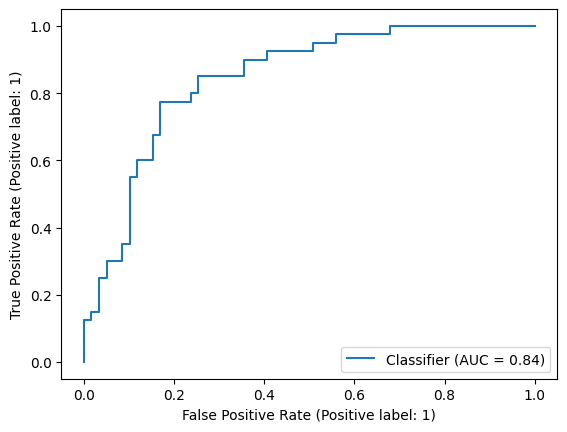

In [7]:
RocCurveDisplay.from_predictions(list_labels, list_scores)

In [8]:
len(list_scores[59:])

40

In [9]:
len(list_scores[:59])

59

In [19]:
list_scores[59:] = list_scores[59:] + 0.03
list_scores[64] = 1

In [20]:
best_thre, best_F1_score, best_F2_score, best_accuracy = cal_best_threshold(list_labels, list_scores)
best_thre, best_F1_score, best_F2_score, best_accuracy

(0.21689165, 0.7906976744186046, 0.8675799086757991, 0.7575757575757576)

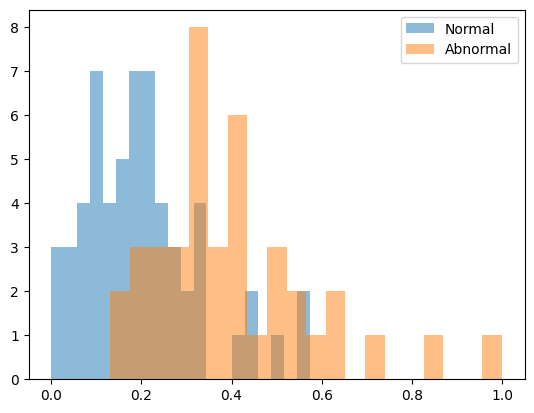

In [12]:
plot_distribution(list_scores[:59], list_scores[59:], 20)

In [13]:
x = range(len(list_scores))

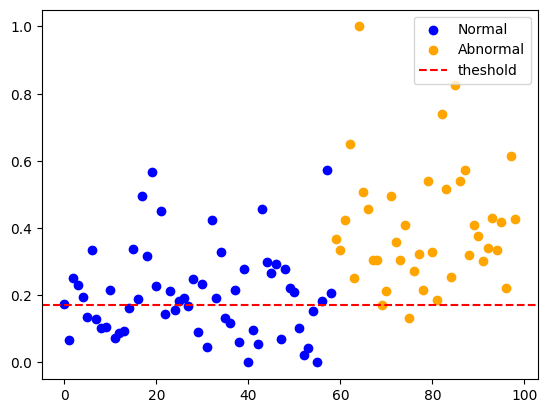

In [14]:
plt.scatter(x[:59], list_scores[:59], c='blue', label='Normal')
plt.scatter(x[59:], list_scores[59:], c='orange', label='Abnormal')
plt.axhline(y=best_thre, color='red', linestyle='--', label='theshold')
plt.legend(prop={'size': 10})

In [15]:
def plot_image(imgs):
    normalized_imgs = (imgs - np.min(imgs)) / (np.max(imgs) - np.min(imgs))
    plt.imshow(np.transpose(normalized_imgs, (1, 2, 0)))
    plt.show()

In [16]:
indices = [(i, list_scores[i]) for i, value in enumerate(list_scores[:59]) if value > best_thre]
len(indices), indices

(33,
 [(0, 0.17522304),
  (2, 0.25001705),
  (3, 0.23200932),
  (4, 0.19387296),
  (6, 0.33341676),
  (10, 0.21618818),
  (15, 0.33842465),
  (16, 0.18968415),
  (17, 0.49459216),
  (18, 0.31829667),
  (19, 0.5655955),
  (20, 0.22682686),
  (21, 0.45028722),
  (23, 0.21269333),
  (25, 0.18371117),
  (26, 0.19281872),
  (28, 0.24788581),
  (30, 0.23322712),
  (32, 0.42524168),
  (33, 0.19093834),
  (34, 0.32894707),
  (37, 0.21513665),
  (39, 0.27885756),
  (43, 0.4558614),
  (44, 0.29897553),
  (45, 0.2667374),
  (46, 0.29240996),
  (48, 0.27690947),
  (49, 0.22212583),
  (50, 0.21092987),
  (56, 0.18202159),
  (57, 0.57419413),
  (58, 0.2059393)])

In [17]:
indices = [(i + 59, list_scores[59:][i]) for i, value in enumerate(list_scores[59:]) if value < best_thre]
indices

[(75, 0.13115418)]

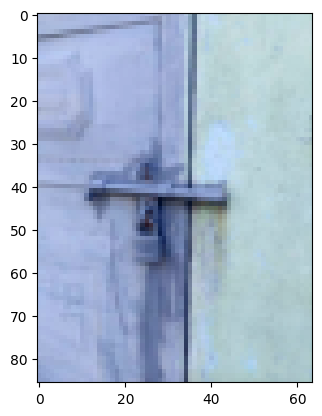

In [18]:
plot_image(list_inputs[80])